In [23]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from tqdm import tqdm

# Ensure the appropriate backend for Matplotlib based on your OS
import matplotlib
matplotlib.use('Agg')
%matplotlib inline

# Import custom modules
import sys
sys.path.append(os.path.join(sys.path[0], '..'))
from metrics import evaluation_metrics
from metrics import cls_feature_class

# Constants
HOP_LENGTH_SECONDS = 0.02
BASELINE = "output"
DATE = '2023-09-28_22-26-44'

# Define the class dictionary
class_dict = {
    'crane': 0,
    'piledriver': 1,
    'saw': 2,
    'excavator': 3,
    'pneumaticbreaker': 4,
    'concretepumper': 5,
    'forklift': 6
}

# Function to collect classwise data
def collect_classwise_data(input_dict):
    output_dict = {}
    for key, values in input_dict.items():
        for seld in values:
            class_name = seld[0]
            if class_name not in output_dict:
                output_dict[class_name] = []
            output_dict[class_name].append([key, class_name, seld[1], seld[2]])
    return output_dict

# Function to plot data
def plot_data(plot_data, hop_length_seconds, index, x_length, class_dict, plot_x_axis=False):
    color_map = ['b', 'r', 'g', 'y', 'k', 'c', 'm']
    for class_index, data_points in plot_data.items():
        time_axis = np.array(data_points)[:, 0] * hop_length_seconds
        y_axis = np.array(data_points)[:, index]
        label = list(class_dict.keys())[list(class_dict.values()).index(class_index)]
        plt.plot(time_axis, y_axis, marker='.', color=color_map[class_index], linestyle='None', markersize=4, label=label)
    plt.grid()
    plt.xlim([-0.2, x_length])
    if not plot_x_axis:
        plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

def main():
    pred_dir = f'{BASELINE}/meta_plot/{DATE}/'
    aud_dir = f'{BASELINE}/audio/{DATE}/'

    # Get all the CSV files in the predicted directory
    predicted_files = [os.path.join(pred_dir, f) for f in os.listdir(pred_dir) if f.endswith('.csv')]
    print(predicted_files)

    x_length = 5.2

    for pred in tqdm(sorted(predicted_files[:1])):
        pred_dict = evaluation_metrics.load_output_format_file(pred)
        pred_data = collect_classwise_data(pred_dict)

        # Load the reference output format
        feat_cls = cls_feature_class.FeatureClass()
        num_classes = len(feat_cls.get_classes())

        # Load the audio and extract the spectrogram
        pred_filename = os.path.basename(pred)
        audio, fs = feat_cls._load_audio(os.path.join(aud_dir, pred_filename.split('.')[0]) + '.wav')
        stft = np.abs(np.squeeze(feat_cls._spectrogram(audio[:, :1])))
        stft = librosa.amplitude_to_db(stft, ref=np.max)

        fig1 = plt.figure(figsize=(15, 10), constrained_layout=True)
        gs = gridspec.GridSpec(ncols=1, nrows=1, figure=fig1)
        plot_data(pred_data, HOP_LENGTH_SECONDS, index=2, x_length=x_length, class_dict=class_dict)
        plt.ylim([-10, num_classes + 370])
        plt.title('DOA Estimation')

        # Add a legend
        plt.legend()

        # Display the plot
        plt.show()

        # Save the figure to a file in the "figures" directory
        fig1.savefig(os.path.join(pred_dir, pred_filename.split('.')[0]))


['output/meta_plot/2023-09-28_22-26-44/split5_ID.wav.csv', 'output/meta_plot/2023-09-28_22-26-44/doas.csv', 'output/meta_plot/2023-09-28_22-26-44/events.csv']


  0%|          | 0/1 [00:00<?, ?it/s]

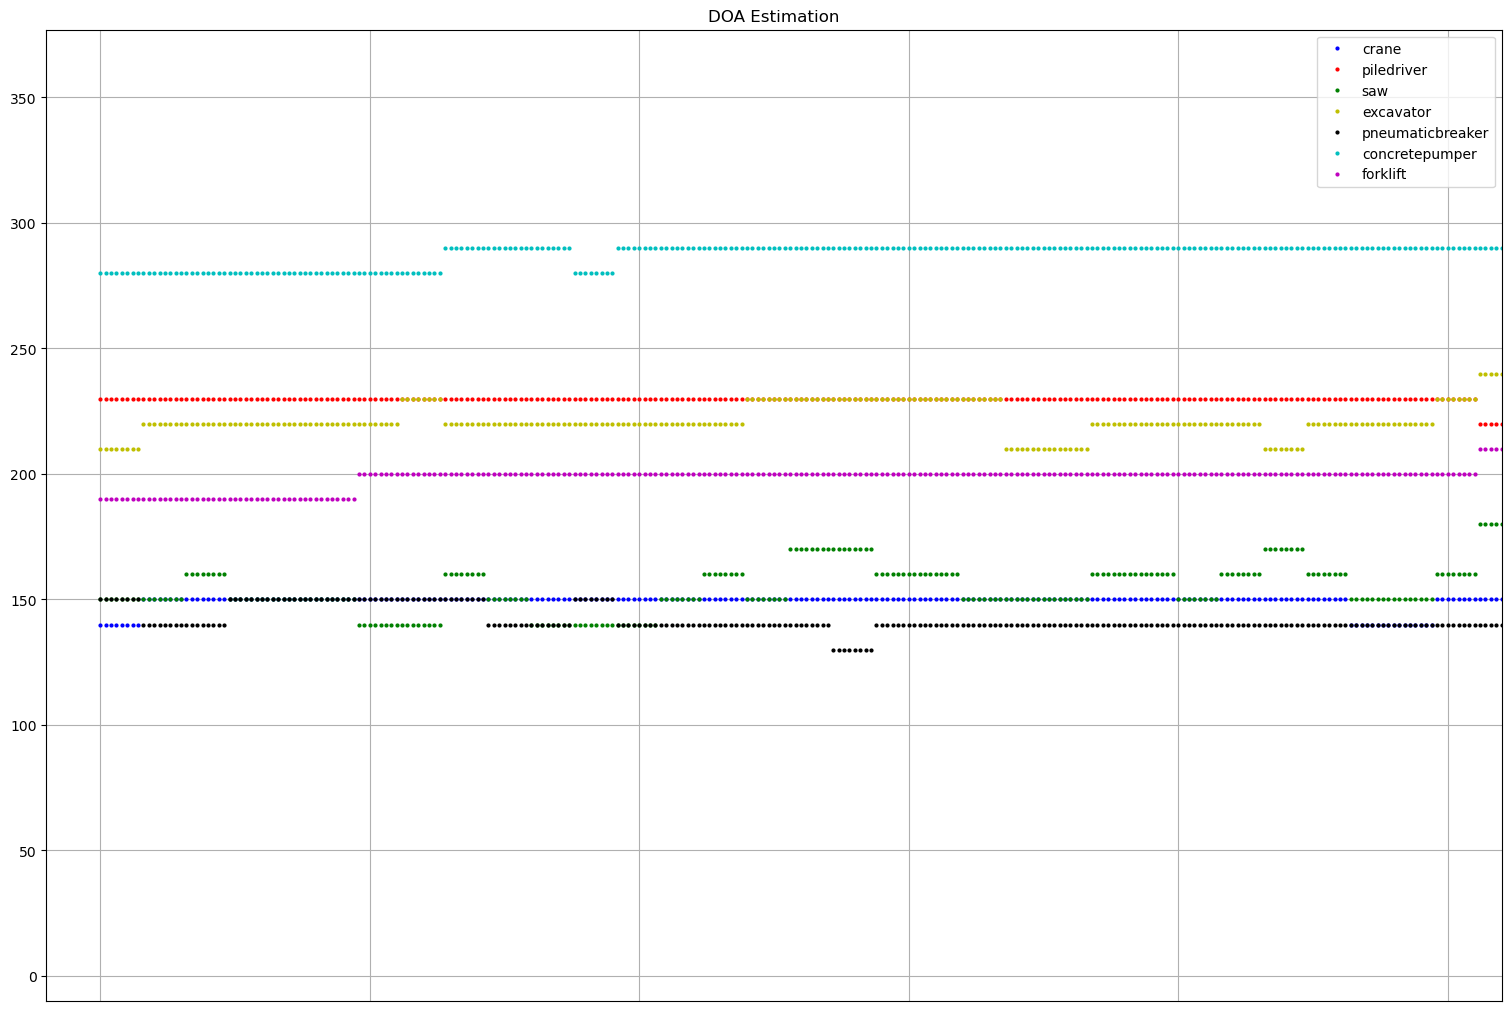

100%|██████████| 1/1 [00:00<00:00,  1.90it/s]


In [24]:
if __name__ == "__main__":
    main()